In [33]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [34]:
import numpy as np
import pandas as pd

In [35]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [36]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [37]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [38]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [39]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [40]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [41]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2016-08-23


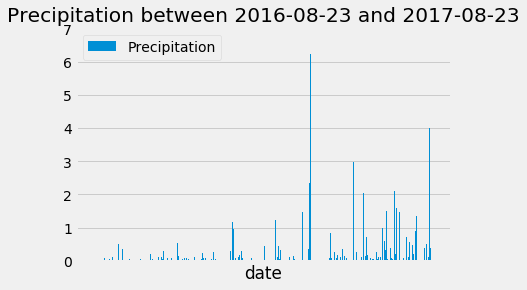

In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#The most recent data seems to be from 2017-08-23, so I"ll take the most recent 12 months, which is what I believe is being asked.
lastDay=session.query(Measurement).order_by(Measurement.id.desc()).first()


# Calculate the date 1 year ago from the last data point in the database
firstYear=int(lastDay.date[0:4])-1

firstDay=str(firstYear)+lastDay.date[4:]
print(firstDay)


# Perform a query to retrieve the data and precipitation scores
mydata=session.query(Measurement).filter(Measurement.date>=firstDay)


# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.read_sql_query(mydata.statement,mydata.session.bind)

# Sort the dataframe by date
df.sort_values(by='date')
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(df.index,df['prcp'],label="Precipitation")
plt.title("Precipitation between 2016-08-23 and 2017-08-23")
plt.xticks([])
plt.xlabel("date")
plt.legend()
plt.show()

![precipitation](Images/precipitation.png)

In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df['precipitation']=df['prcp']
df['precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

![describe](Images/describe.png)

In [44]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()
a=session.query(Station)
b=pd.read_sql_query(a.statement,a.session.bind)
b

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [45]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
MyData2 = session.query(Measurement,Station.name,Station.latitude,Station.longitude,Station.elevation).filter(Station.station==Measurement.station)

#Feed the data into a new data frame
dfStation=pd.read_sql_query(MyData2.statement,MyData2.session.bind)

#Create a new Frame to do the count while perserving the other data
dfStationCount=pd.DataFrame()

#Migrate over 2 columns, and get the count
dfStationCount['station']=dfStation['station']
dfStationCount['count']=dfStation['id']
dfStationCount=dfStationCount.groupby('station').count()
dfStationCount.sort_values(by='count',ascending=False)


,count
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [46]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#Max
max=dfStation[['station','tobs']].groupby('station').max()
max

,tobs
station,
USC00511918,87.0
USC00513117,85.0
USC00514830,85.0
USC00516128,84.0
USC00517948,87.0
USC00518838,83.0
USC00519281,85.0
USC00519397,87.0
USC00519523,85.0


In [47]:
#min
min=dfStation[['station','tobs']].groupby('station').min()
min

,tobs
station,
USC00511918,53.0
USC00513117,59.0
USC00514830,58.0
USC00516128,58.0
USC00517948,58.0
USC00518838,58.0
USC00519281,54.0
USC00519397,56.0
USC00519523,56.0


In [48]:
#avg
mean=dfStation[['station','tobs']].groupby('station').mean()
mean

,tobs
station,
USC00511918,71.615968
USC00513117,72.689184
USC00514830,74.873297
USC00516128,70.915008
USC00517948,74.684402
USC00518838,72.724070
USC00519281,71.663781
USC00519397,74.553231
USC00519523,74.543649


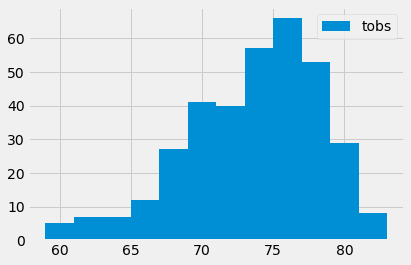

In [49]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
myData3=session.query(Measurement).filter(Measurement.station=='USC00519281').filter(Measurement.date>=firstDay)
dfBusy=pd.read_sql_query(myData3.statement,myData3.session.bind)
plt.hist(dfBusy['tobs'],12,label='tobs')
plt.legend()

![precipitation](Images/station-histogram.png)

In [50]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [51]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#Trip will be from August 3 to August 18
temp=calc_temps('2017-08-03','2017-08-18')
print(temp)

[(70.0, 78.86153846153846, 84.0)]


Text(0.5, 1.0, 'Trip Avg Temp')

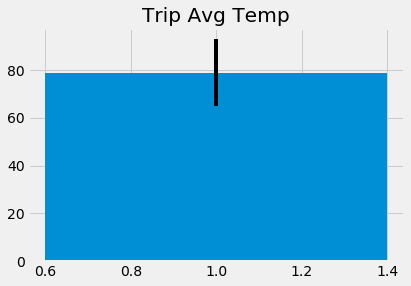

In [52]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(x=1,height=temp[0][1],yerr=temp[0][2]-temp[0][0])
plt.title("Trip Avg Temp")

In [53]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
dfPrecip=dfStation[['station','prcp','date','name','latitude','longitude','elevation']].where(dfStation['date']>='2017-08-03')
dfPrecip=dfPrecip.where(dfStation['date']<='2017-08-18')
dfPrecip=dfPrecip.dropna()

totalprecip=dfPrecip.groupby(['station','name','latitude','longitude','elevation']).sum()

totalprecip


,,,,,prcp
station,name,latitude,longitude,elevation,
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.16
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.00
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.57
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.26


## Optional Challenge Assignment

In [54]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [55]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [56]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [57]:
# Plot the daily normals as an area plot with `stacked=False`
